In [1]:
import glob
import os
import numpy as np
import cv2
from numpy import dot
from numpy.linalg import norm
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

In [54]:
class ClusterFace():
    def __init__(self, dir_address='./', radius=0.2 ):
        self.extensions  = ['jpg','png','jpeg']
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval()
        self.mtcnn = MTCNN(image_size=160)
        self.dir_address = dir_address
        self.radius      = radius
        self.images_address = self.get_image_names(self.dir_address)
        self.data = self.get_embedding_face(self.images_address)
    


    def get_image_names(self, address):
        files = []
        for extension in self.extensions:
            files.extend(glob.glob(os.path.join(self.dir_address,f'*.{extension}')))
        return files
        


    def cosine_similarity(self,vec1,vec2):
        cos_sim = 1- (dot(vec1, vec2)/(norm(vec1)*norm(vec2)))
        return cos_sim
   
    def get_embedding_face(self, images_address:str):
        data = []
        for image_address in images_address:
            img1 = cv2.imread(image_address)
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
            img_cropped1 = self.mtcnn(img1)
            img_embedding1 = self.resnet(img_cropped1.unsqueeze(0))
            a = img_embedding1[0].cpu().detach().numpy()
            data.append(img_embedding1[0].cpu().detach().numpy() )
            # data.append(list(a))
        return data



    def fit(self):
        centroids = {}
        data = self.data

        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            new_centroids_data = {}
            for i in centroids:
                in_bandwidth = []
                in_bandwidth_idx = []
                centroid = centroids[i]
                for idx, featureset in enumerate(data):
                    if self.cosine_similarity(featureset,centroid) < self.radius:
                        in_bandwidth.append(featureset)
                        in_bandwidth_idx.append(idx)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))
                new_centroids_data[i] = in_bandwidth_idx

            uniques = sorted(list(set(new_centroids)))

            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids          = centroids
        self.new_centroids_data = new_centroids_data
        
        
 
    def get_max_class(self):
        return max(len(v) for k,v in self.new_centroids_data.items())

    
    def show_results(self):
        print (f'we have {len(self.centroids)} persons in the images as follow:')
        for idx in range (len(self.centroids)):
            print ( f'for person {idx}:')
            for j in range (len((self.new_centroids_data[idx]))):
                print (self.images_address[self.new_centroids_data[idx][j]])

    def draw_results(self):
        fig = plt.figure()
        rows = len(self.centroids)
        columns = self.get_max_class()
        f, axarr = plt.subplots(rows,columns)
        for idx in range (rows):
            for j in range (len((self.new_centroids_data[idx]))):
                img = cv2.imread(self.images_address[self.new_centroids_data[idx][j]])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axarr[idx, j].imshow(img)





In [55]:
CF = ClusterFace('./imgs/')
CF.fit()

<Figure size 432x288 with 0 Axes>

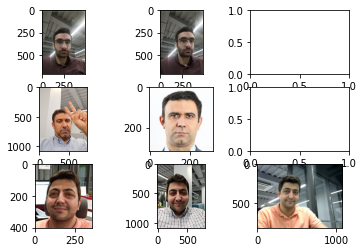

In [56]:
CF.draw_results()